## Data Loading & Preprocessing

```
Data is loaded, then split into training & testing sets.
Standard scaling is also applied to images.
```

### Download Data & Load as numPy Arrays

To avoid downloading data set to disk use **sklearn.datasets.fetch_lfw_people**

In [1]:
from sklearn.datasets import fetch_lfw_people


people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Introspect the image arrays
n_samples, height, width = people.images.shape

X = people.data
n_features = X.shape[1]

y = people.target
target_names = people.target_names
n_classes = target_names.shape[0]

print("Total Dataset Size:")
print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"n_classes: {n_classes}")


Total Dataset Size:
n_samples: 1288
n_features: 1850
n_classes: 7


### Split Data into Training & Test Sets

Apply standardised scaling
75% Training | 25% Testing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(
    # Prior to split, 'random_state' controls the amount of data mixing
    # No specific reason as to 42, just allows same result to be produced across a different run
    X, y, test_size=0.25, random_state=42
)

# Remove mean & scale to unit variance to standardise features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Exploratory Data Analysis

```
Dimensionality Reduction w/ Principal Component Analysis (PCA)
```

In [3]:
from time import time
from sklearn.decomposition import PCA


# Compute PCA
n_components = 150
t0 = time()

pca = PCA(n_components = n_components,
          svd_solver= "randomized",
          whiten = True
          ).fit(X_train)

print(f"Extracting the top {n_components} from {X_train.shape[0]} faces...")
print(f"done in {time() - t0}s")


# Data Transformation
eigenfaces = pca.components_.reshape((n_components, height, width))

print("Projecting input data on the eigenfaces orthonormal basis")

t0 = time()

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"done in {time() - t0}s")

Extracting the top 150 from 966 faces...
done in 1.6933419704437256s
Projecting input data on the eigenfaces orthonormal basis
done in 0.06855106353759766s


## ML Model Training

```
Support Vector Machine Classification
```

In [4]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

print("Fitting classifier to training data set...")

t0 = time()

# Logarithmic probability distribution parameters
params = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1)
}

clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), params, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)

print(f"done in {time() - t0}s")
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting classifier to training data set...
done in 6.792762279510498s
Best estimator found by grid search:
SVC(C=11131.967725028177, class_weight='balanced', gamma=0.0017672586053837356)


## Model Evaluation

### Quantitative

Predicting names on test data set...
done in 0.046175241470336914
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.78      0.88      0.83        60
  Donald Rumsfeld       0.86      0.70      0.78        27
    George W Bush       0.89      0.92      0.91       146
Gerhard Schroeder       0.83      0.80      0.82        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.85       322
        macro avg       0.82      0.78      0.79       322
     weighted avg       0.86      0.85      0.85       322

mkdir: cannot create directory ‘../results/’: File exists


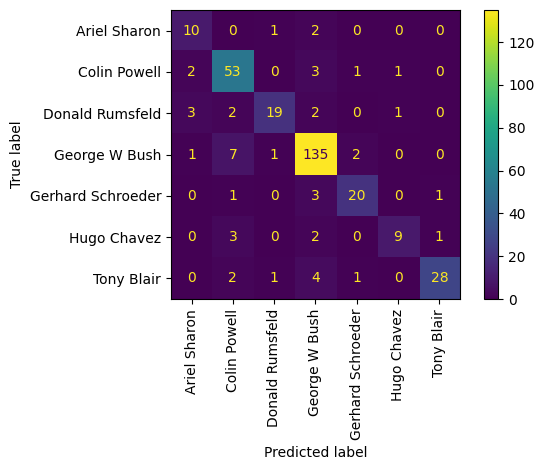

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print("Predicting names on test data set...")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(f"done in {time() - t0}")

# Create report explaining model efficiency - precision, recall, f1 score, support
print(classification_report(y_test, y_pred, target_names = target_names))

ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels= target_names, xticks_rotation = "vertical"
)

%mkdir ../results/
plt.tight_layout()
plt.savefig("../results/quantitative.png")
plt.show()


### Qualitative

mkdir: cannot create directory ‘../results/’: File exists


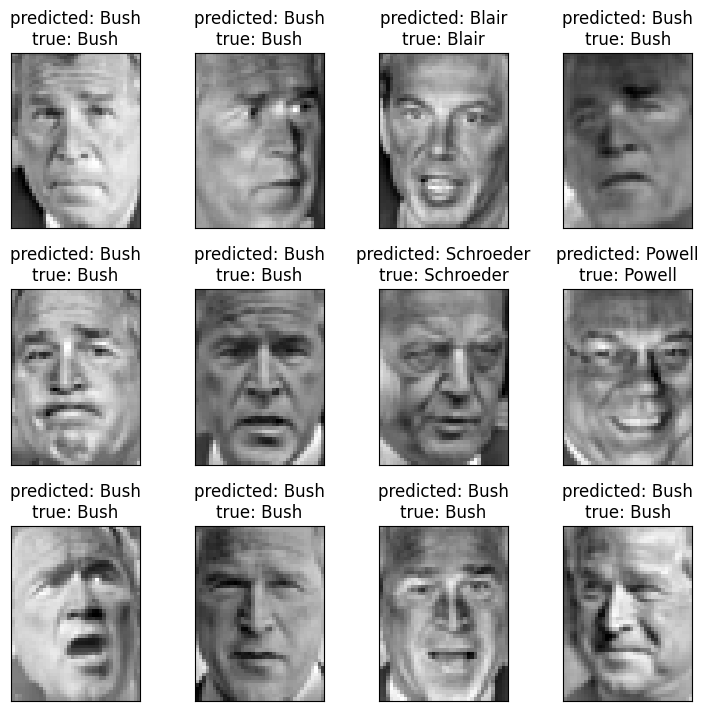

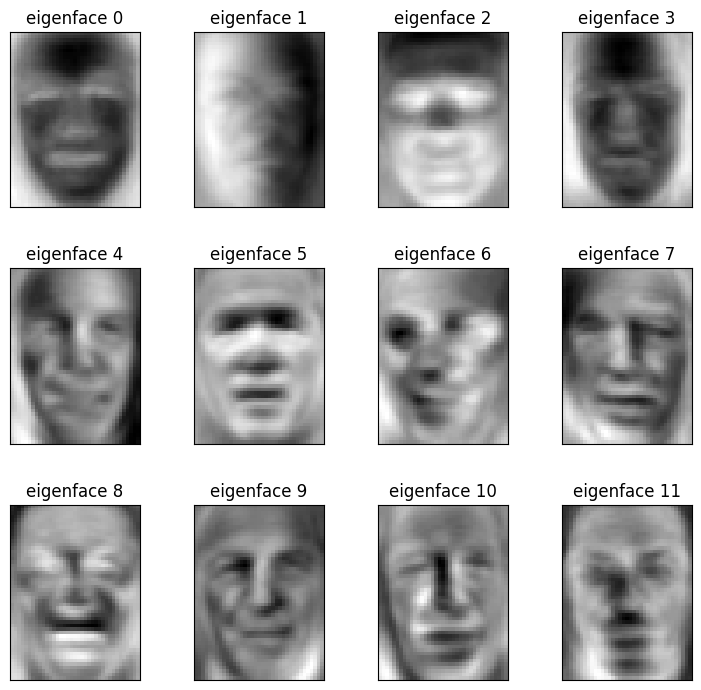

In [6]:
# Helper functions
def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4):
    # Plot figure
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    # Spacing for clarity
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    
    # Iterate through each subplot
    for i in range(n_row * n_col):
        # Create subplots
        plt.subplot(n_row, n_col, i + 1)
        # Show image
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        # Plot title & remove axes
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        

def title(y_pred, y_test, target_names, i):
    # Predicted & actual names for each image
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    
    return f"predicted: {pred_name}\ntrue: {true_name}"


%mkdir ../results/

# Predictions...
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]
plot_gallery(X_test, prediction_titles, height, width)
plt.savefig('../results/qualitative1.png')

# Eigenfaces...
eigenface_titles = [
    f"eigenface {i}" for i in range(eigenfaces.shape[0])
]
plot_gallery(eigenfaces, eigenface_titles, height, width)
plt.savefig('../results/qualitative2.png')

plt.show()